In [ ]:
from tqdm import tqdm
import torch.nn as nn
from scipy.spatial.distance import directed_hausdorff
from glob import glob
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from TransUNet.networks.vit_seg_modeling import CONFIGS as CONFIGS_ViT_seg
from TransUNet.networks.vit_seg_modeling import VisionTransformer as ViT_seg
from monai.networks.nets import SwinUNETR
import torch.nn as nn
import os, urllib.request
import matplotlib.gridspec as gridspec

In [6]:
# Create Dataframe
def create_df(data_dir):
    images_paths = []
    masks_paths = glob(f'{data_dir}/*/*_mask*')
    for i in masks_paths:
        images_paths.append(i.replace('_mask', ''))
    df = pd.DataFrame(data= {'images': images_paths, 'masks': masks_paths})
    return df

data_dir = './data/kaggle_3m'
df = create_df(data_dir)
df.head()

images  \
0  ./data/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT...   
1  ./data/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT...   
2  ./data/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT...   
3  ./data/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT...   
4  ./data/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT...   

                                               masks  
0  ./data/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT...  
1  ./data/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT...  
2  ./data/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT...  
3  ./data/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT...  
4  ./data/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT...

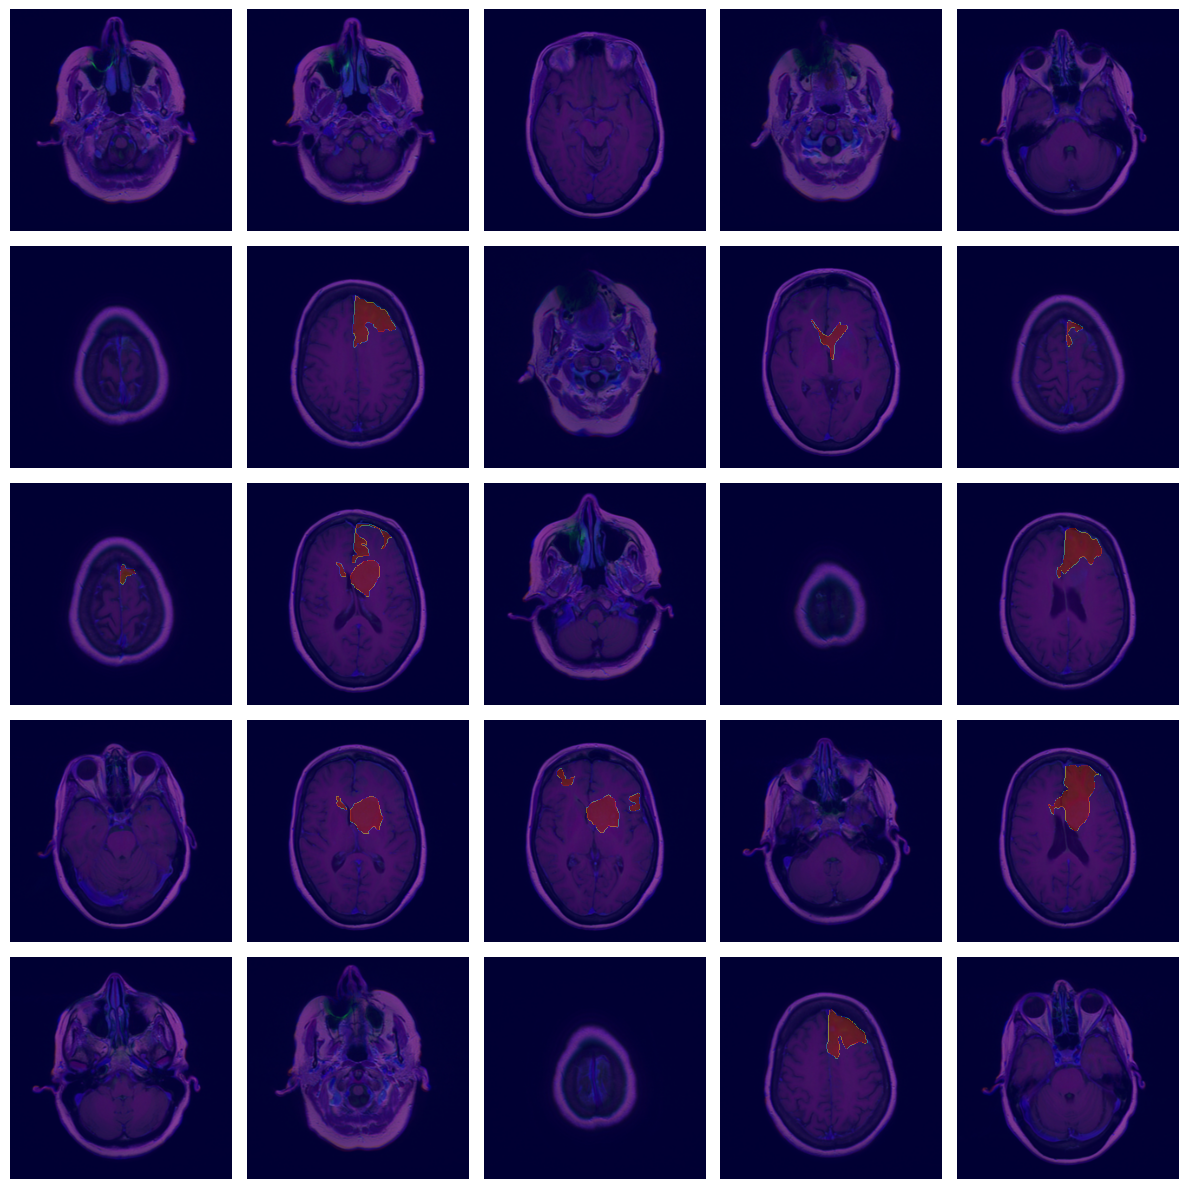

In [8]:
# Function to display images and masks
def show_images(images, masks):
    plt.figure(figsize=(12, 12))
    for i in range(25):
        plt.subplot(5, 5, i + 1)

        img_path = images[i]
        mask_path = masks[i]

        # Read and convert image to RGB
        image = cv.imread(img_path)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

        # Read the mask
        mask = cv.imread(mask_path, cv.IMREAD_GRAYSCALE) 

        # Display the image
        plt.imshow(image)
        plt.imshow(mask, cmap="jet", alpha=0.4) 
        plt.axis("off")

    plt.tight_layout()
    plt.show()

show_images(list(df["images"]), list(df["masks"]))

In [ ]:
class MaskBinarize:
    def __call__(self, msk):
        msk = (msk > 0.5).float()  
        return msk

def img_to_tensor(df, mask=False):
    if mask:
        transform = transforms.Compose([
            transforms.ToTensor(),          
            MaskBinarize()
        ])
    else:
        transform = transforms.Compose([
            transforms.ToTensor(),          
        ])
    
    image_tensors = []
    image_paths_used = []

    for img_path in df:
        try:
            if mask:
                img = Image.open(img_path).convert("L")  # grayscale mask
            else:
                img = Image.open(img_path).convert("L")  # grayscale images are used for training

            img_tensor = transform(img)
            image_tensors.append(img_tensor)
            image_paths_used.append(img_path)

        except Exception as e:
            print(f"Error loading image {img_path}: {e}")

    if image_tensors:
        image_tensors = torch.stack(image_tensors)
        print(f"Loaded {len(image_tensors)} images successfully.")
        return image_tensors, image_paths_used
    else:
        print("No valid images were loaded.")
        return None, []


In [ ]:
# Step 1: Load all image tensors + paths
image_tensors, image_rgb_paths = img_to_tensor(df["images"])
mask_tensors, mask_paths = img_to_tensor(df["masks"], mask=True)

# Step 2: Split into train and temp (val + test), with train being 80%
train_img, temp_img, train_mask, temp_mask, train_img_paths, temp_img_paths = train_test_split(
    image_tensors, mask_tensors, image_rgb_paths, test_size=0.2, random_state=42
)

# Split the mask paths accordingly (if you have kept the mask paths)
_, _, _, _, _, temp_mask_paths = train_test_split(
    image_tensors, mask_tensors, mask_paths, test_size=0.2, random_state=42
)

# Step 3: Split temp further into val and test, each taking up 10% (half of temp)
val_img, test_img, val_mask, test_mask, val_img_paths, test_img_paths = train_test_split(
    temp_img, temp_mask, temp_img_paths, test_size=0.5, random_state=42
)

_, _, _, _, val_mask_paths, test_mask_paths = train_test_split(
    temp_img, temp_mask, temp_mask_paths, test_size=0.5, random_state=42
)


Loaded 3929 images successfully.
Loaded 3929 images successfully.


In [19]:
train_dataset = TensorDataset(train_img, train_mask)
val_dataset = TensorDataset(val_img, val_mask)
test_dataset = TensorDataset(test_img, test_mask)

trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
valloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)
testloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

# -------------------------
# Model 1 UNet

In [13]:
def dice_coefficient(y_pred, y_true):
    intersection = torch.sum(y_pred * y_true)
    union = torch.sum(y_pred) + torch.sum(y_true) + 1e-6

    dice = 2 * intersection / union

    return dice

In [14]:
def compute_metrics(pred, target, eps=1e-6):
    """
    pred: binary prediction tensor (0/1), same shape as target
    target: ground truth mask (0/1)
    """
    TP = torch.sum(pred * target)
    FP = torch.sum(pred * (1 - target))
    FN = torch.sum((1 - pred) * target)

    iou = TP / (TP + FP + FN + eps)
    recall = TP / (TP + FN + eps)

    return iou.item(), recall.item()


# -------------------------
# Model 2 TransUNet

In [32]:


class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
    
    def forward(self, pred, true):
        pred = pred.view(-1)
        true = true.view(-1)
        intersection = (pred*true).sum()
        dice = (2*intersection + self.smooth) / (pred.sum() + true.sum() + self.smooth)
        return 1 - dice

class BCEDiceLoss(nn.Module):
    def __init__(self, bce_weight=0.5):
        super().__init__()
        self.bce = nn.BCELoss()
        self.dice = DiceLoss()
        self.bce_weight = bce_weight

    def forward(self, pred, true):
        bce_loss = self.bce(pred, true)
        dice_loss = self.dice(pred, true)
        return self.bce_weight * bce_loss + (1-self.bce_weight) * dice_loss
        

In [ ]:
os.makedirs("TransUNet/model/vit_checkpoint/imagenet21k", exist_ok=True)
url = "https://storage.googleapis.com/vit_models/imagenet21k/R50+ViT-B_16.npz"
save_path = "TransUNet/model/vit_checkpoint/imagenet21k/R50+ViT-B_16.npz"

urllib.request.urlretrieve(url, save_path)
print("✅ Weight file download complete：", save_path)


✅ 权重文件下载完成： TransUNet/model/vit_checkpoint/imagenet21k/R50+ViT-B_16.npz


In [34]:
vit_name = 'R50-ViT-B_16'
config_vit = CONFIGS_ViT_seg[vit_name]
config_vit.n_classes = 1
config_vit.n_skip = 3

model = ViT_seg(config_vit, img_size=256, num_classes=1).cuda()
load_path = config_vit.pretrained_path.split('..')[-1]
load_path = 'TransUNet' + load_path

model.load_from(weights=np.load(load_path))
loss_function = BCEDiceLoss(bce_weight=0.5)
optimizer = torch.optim.Adam(model.parameters(), 1e-3)

load_pretrained: grid-size from 14 to 16


In [ ]:
total_epoch = 200
best_dice = 0.0
patience = 10  # adjustable
counter = 0
early_stop = False

print('Begin to train!!')
for epoch in range(total_epoch):
    if early_stop:
        print("Early stopping triggered at epoch", epoch)
        break

    model.train()
    epoch_loss = 0.0
    batch_idx = 0
    for img, mask in tqdm(trainloader):
        batch_idx += 1
        img, mask = img.cuda(), mask.cuda().float()
        optimizer.zero_grad()
        output = model(img)
        output = torch.sigmoid(output)
        
        loss = loss_function(output, mask)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= batch_idx
    print('Epoch {} loss: {:.4f}'.format(epoch, epoch_loss))

    if (epoch + 1) % 5 == 0:
        model.eval()
        print('Begin to validate!!')
        with torch.no_grad():
            val_loss = 0.0
            val_dice = 0.0
            val_idx = 0
            for val_img, val_mask in tqdm(valloader):
                val_idx += 1
                val_img, val_mask = val_img.cuda(), val_mask.cuda().float()
                val_output = model(val_img)
                val_output = torch.sigmoid(val_output)

                loss = loss_function(val_output, val_mask)
                val_loss += loss.item()
                val_dice += dice_coefficient(val_output, val_mask)
        val_loss /= val_idx
        val_dice /= val_idx

        print('Validation ended !!')
        print('Dice: {:.4f}, Loss: {:.4f}'.format(val_dice, val_loss))

        if val_dice > best_dice:
            best_dice = val_dice
            counter = 0
            torch.save(model.state_dict(), 'TransUNet_model.pth')
            print(f"✅ New best Dice {best_dice:.4f}, model saved.")
        else:
            counter += 1
            print(f"⚠️  No improvement. Early stop counter: {counter}/{patience}")
            if counter >= patience:
                early_stop = True

print('Training ended !!')


Begin to train!!


100%|██████████| 50/50 [01:27<00:00,  1.74s/it]


Epoch 0 loss: 0.5912


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 1 loss: 0.3427


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 2 loss: 0.2431


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 3 loss: 0.2093


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 4 loss: 0.1904
Begin to validate!!


100%|██████████| 7/7 [00:03<00:00,  1.99it/s]


Validation ended !!
Dice: 0.5832, Loss: 0.2512
✅ New best Dice 0.5832, model saved.


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 5 loss: 0.1743


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 6 loss: 0.1631


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 7 loss: 0.1494


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 8 loss: 0.1368


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 9 loss: 0.1305
Begin to validate!!


100%|██████████| 7/7 [00:03<00:00,  1.96it/s]


Validation ended !!
Dice: 0.4380, Loss: 0.3078
⚠️  No improvement. Early stop counter: 1/10


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 10 loss: 0.1282


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 11 loss: 0.1175


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 12 loss: 0.1161


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 13 loss: 0.1098


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 14 loss: 0.1204
Begin to validate!!


100%|██████████| 7/7 [00:03<00:00,  2.03it/s]


Validation ended !!
Dice: 0.1196, Loss: 0.4822
⚠️  No improvement. Early stop counter: 2/10


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 15 loss: 0.1064


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 16 loss: 0.1002


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 17 loss: 0.1017


100%|██████████| 50/50 [00:44<00:00,  1.13it/s]


Epoch 18 loss: 0.0986


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 19 loss: 0.1048
Begin to validate!!


100%|██████████| 7/7 [00:03<00:00,  1.93it/s]


Validation ended !!
Dice: 0.8061, Loss: 0.1061
✅ New best Dice 0.8061, model saved.


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 20 loss: 0.0926


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 21 loss: 0.0778


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 22 loss: 0.0775


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 23 loss: 0.0802


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 24 loss: 0.0838
Begin to validate!!


100%|██████████| 7/7 [00:03<00:00,  1.98it/s]


Validation ended !!
Dice: 0.8305, Loss: 0.0945
✅ New best Dice 0.8305, model saved.


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 25 loss: 0.0883


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 26 loss: 0.1030


100%|██████████| 50/50 [00:44<00:00,  1.11it/s]


Epoch 27 loss: 0.0765


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 28 loss: 0.0753


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 29 loss: 0.0744
Begin to validate!!


100%|██████████| 7/7 [00:03<00:00,  2.01it/s]


Validation ended !!
Dice: 0.8063, Loss: 0.1063
⚠️  No improvement. Early stop counter: 1/10


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 30 loss: 0.0677


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 31 loss: 0.0654


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 32 loss: 0.0629


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 33 loss: 0.0637


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 34 loss: 0.0595
Begin to validate!!


100%|██████████| 7/7 [00:03<00:00,  1.93it/s]


Validation ended !!
Dice: 0.8033, Loss: 0.1091
⚠️  No improvement. Early stop counter: 2/10


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 35 loss: 0.0616


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 36 loss: 0.0737


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 37 loss: 0.0753


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 38 loss: 0.0655


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 39 loss: 0.0797
Begin to validate!!


100%|██████████| 7/7 [00:03<00:00,  2.01it/s]


Validation ended !!
Dice: 0.2990, Loss: 0.3977
⚠️  No improvement. Early stop counter: 3/10


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 40 loss: 0.0685


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 41 loss: 0.0596


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 42 loss: 0.0555


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 43 loss: 0.0540


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 44 loss: 0.0581
Begin to validate!!


100%|██████████| 7/7 [00:03<00:00,  2.00it/s]


Validation ended !!
Dice: 0.8478, Loss: 0.0851
✅ New best Dice 0.8478, model saved.


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 45 loss: 0.0619


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 46 loss: 0.0583


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 47 loss: 0.0614


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 48 loss: 0.0565


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 49 loss: 0.0526
Begin to validate!!


100%|██████████| 7/7 [00:03<00:00,  1.93it/s]


Validation ended !!
Dice: 0.8297, Loss: 0.0945
⚠️  No improvement. Early stop counter: 1/10


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 50 loss: 0.0511


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 51 loss: 0.0508


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 52 loss: 0.0478


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 53 loss: 0.0473


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 54 loss: 0.0544
Begin to validate!!


100%|██████████| 7/7 [00:03<00:00,  2.00it/s]


Validation ended !!
Dice: 0.0331, Loss: 2.8597
⚠️  No improvement. Early stop counter: 2/10


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 55 loss: 0.0532


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 56 loss: 0.0504


100%|██████████| 50/50 [00:49<00:00,  1.01it/s]


Epoch 57 loss: 0.0480


100%|██████████| 50/50 [00:43<00:00,  1.14it/s]


Epoch 58 loss: 0.0493


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 59 loss: 0.0744
Begin to validate!!


100%|██████████| 7/7 [00:03<00:00,  1.99it/s]


Validation ended !!
Dice: 0.0645, Loss: 1.2603
⚠️  No improvement. Early stop counter: 3/10


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 60 loss: 0.0691


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 61 loss: 0.0541


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 62 loss: 0.0495


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 63 loss: 0.0486


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 64 loss: 0.0442
Begin to validate!!


100%|██████████| 7/7 [00:03<00:00,  1.97it/s]


Validation ended !!
Dice: 0.8484, Loss: 0.0844
✅ New best Dice 0.8484, model saved.


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 65 loss: 0.0415


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 66 loss: 0.0420


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 67 loss: 0.0410


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 68 loss: 0.0423


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 69 loss: 0.0401
Begin to validate!!


100%|██████████| 7/7 [00:03<00:00,  1.99it/s]


Validation ended !!
Dice: 0.8599, Loss: 0.0789
✅ New best Dice 0.8599, model saved.


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 70 loss: 0.0420


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 71 loss: 0.0390


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 72 loss: 0.0398


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 73 loss: 0.0394


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 74 loss: 0.0437
Begin to validate!!


100%|██████████| 7/7 [00:03<00:00,  2.00it/s]


Validation ended !!
Dice: 0.7687, Loss: 0.1308
⚠️  No improvement. Early stop counter: 1/10


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 75 loss: 0.0432


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 76 loss: 0.0389


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 77 loss: 0.0375


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 78 loss: 0.0732


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 79 loss: 0.0736
Begin to validate!!


100%|██████████| 7/7 [00:03<00:00,  2.02it/s]


Validation ended !!
Dice: 0.0872, Loss: 0.9561
⚠️  No improvement. Early stop counter: 2/10


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 80 loss: 0.0561


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 81 loss: 0.0439


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 82 loss: 0.0387


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 83 loss: 0.0367


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 84 loss: 0.0353
Begin to validate!!


100%|██████████| 7/7 [00:03<00:00,  2.01it/s]


Validation ended !!
Dice: 0.8493, Loss: 0.0849
⚠️  No improvement. Early stop counter: 3/10


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 85 loss: 0.0367


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 86 loss: 0.0343


100%|██████████| 50/50 [00:44<00:00,  1.11it/s]


Epoch 87 loss: 0.0326


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 88 loss: 0.0405


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 89 loss: 0.0303
Begin to validate!!


100%|██████████| 7/7 [00:03<00:00,  1.91it/s]


Validation ended !!
Dice: 0.6521, Loss: 0.1986
⚠️  No improvement. Early stop counter: 4/10


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 90 loss: 0.0290


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 91 loss: 0.0285


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 92 loss: 0.0288


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 93 loss: 0.0287


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 94 loss: 0.0284
Begin to validate!!


100%|██████████| 7/7 [00:03<00:00,  1.96it/s]


Validation ended !!
Dice: 0.8151, Loss: 0.1080
⚠️  No improvement. Early stop counter: 5/10


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 95 loss: 0.0577


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 96 loss: 0.0731


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 97 loss: 0.0580


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 98 loss: 0.0446


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 99 loss: 0.0355
Begin to validate!!


100%|██████████| 7/7 [00:03<00:00,  1.97it/s]


Validation ended !!
Dice: 0.5648, Loss: 0.2514
⚠️  No improvement. Early stop counter: 6/10


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 100 loss: 0.0322


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 101 loss: 0.0403


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 102 loss: 0.0391


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 103 loss: 0.0334


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 104 loss: 0.0337
Begin to validate!!


100%|██████████| 7/7 [00:03<00:00,  1.95it/s]


Validation ended !!
Dice: 0.0487, Loss: 1.7830
⚠️  No improvement. Early stop counter: 7/10


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 105 loss: 0.0677


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 106 loss: 0.0481


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 107 loss: 0.0732


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Epoch 108 loss: 0.0548


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 109 loss: 0.0491
Begin to validate!!


100%|██████████| 7/7 [00:03<00:00,  1.97it/s]


Validation ended !!
Dice: 0.8161, Loss: 0.1056
⚠️  No improvement. Early stop counter: 8/10


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 110 loss: 0.0354


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 111 loss: 0.0340


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 112 loss: 0.0649


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 113 loss: 0.0450


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 114 loss: 0.0397
Begin to validate!!


100%|██████████| 7/7 [00:03<00:00,  1.92it/s]


Validation ended !!
Dice: 0.1290, Loss: 0.7391
⚠️  No improvement. Early stop counter: 9/10


100%|██████████| 50/50 [00:43<00:00,  1.16it/s]


Epoch 115 loss: 0.0325


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 116 loss: 0.0285


100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


Epoch 117 loss: 0.0271


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 118 loss: 0.0282


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 119 loss: 0.0261
Begin to validate!!


100%|██████████| 7/7 [00:03<00:00,  2.00it/s]


Validation ended !!
Dice: 0.8380, Loss: 0.0935
⚠️  No improvement. Early stop counter: 10/10
Early stopping triggered at epoch 120
Training ended !!


In [35]:
model.load_state_dict(torch.load('TransUNet_model.pth'))
model.cuda()
model.eval()
batch_idx = 0
test_dice = 0.0
test_hd = 0.0
test_iou = 0.0
test_recall = 0.0

for img, mask in tqdm(testloader):
    batch_idx += 1
    img = img.cuda()
    mask = mask.cuda().float()

    with torch.no_grad():
        raw_output = torch.sigmoid(model(img))
        binary_output = (raw_output > 0.5).float()

        # Dice
        test_dice += dice_coefficient(binary_output, mask)

        # IoU & Recall
        iou, recall = compute_metrics(binary_output, mask)
        test_iou += iou
        test_recall += recall

        # Hausdorff Distance
        hd_output = binary_output.cpu().detach().numpy()
        hd_mask = mask.cpu().detach().numpy()
        hd = 0.0
        for i in range(binary_output.shape[0]):
            hd += directed_hausdorff(hd_output[i].squeeze(), hd_mask[i].squeeze())[0]
        test_hd += hd / binary_output.shape[0]

# Final averaged metrics
test_dice /= batch_idx
test_iou /= batch_idx
test_recall /= batch_idx
test_hd /= batch_idx

print(f'During test of TransUNet_model :\n'
      f'  Dice:   {test_dice:.4f}\n'
      f'  IoU:    {test_iou:.4f}\n'
      f'  Recall: {test_recall:.4f}\n'
      f'  HD:     {test_hd:.4f} pixels')


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
100%|██████████| 7/7 [00:12<00:00,  1.71s/it]

During test of TransUNet_model :
  Dice:   0.8569
  IoU:    0.7520
  Recall: 0.8094
  HD:     0.8693 pixels


This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


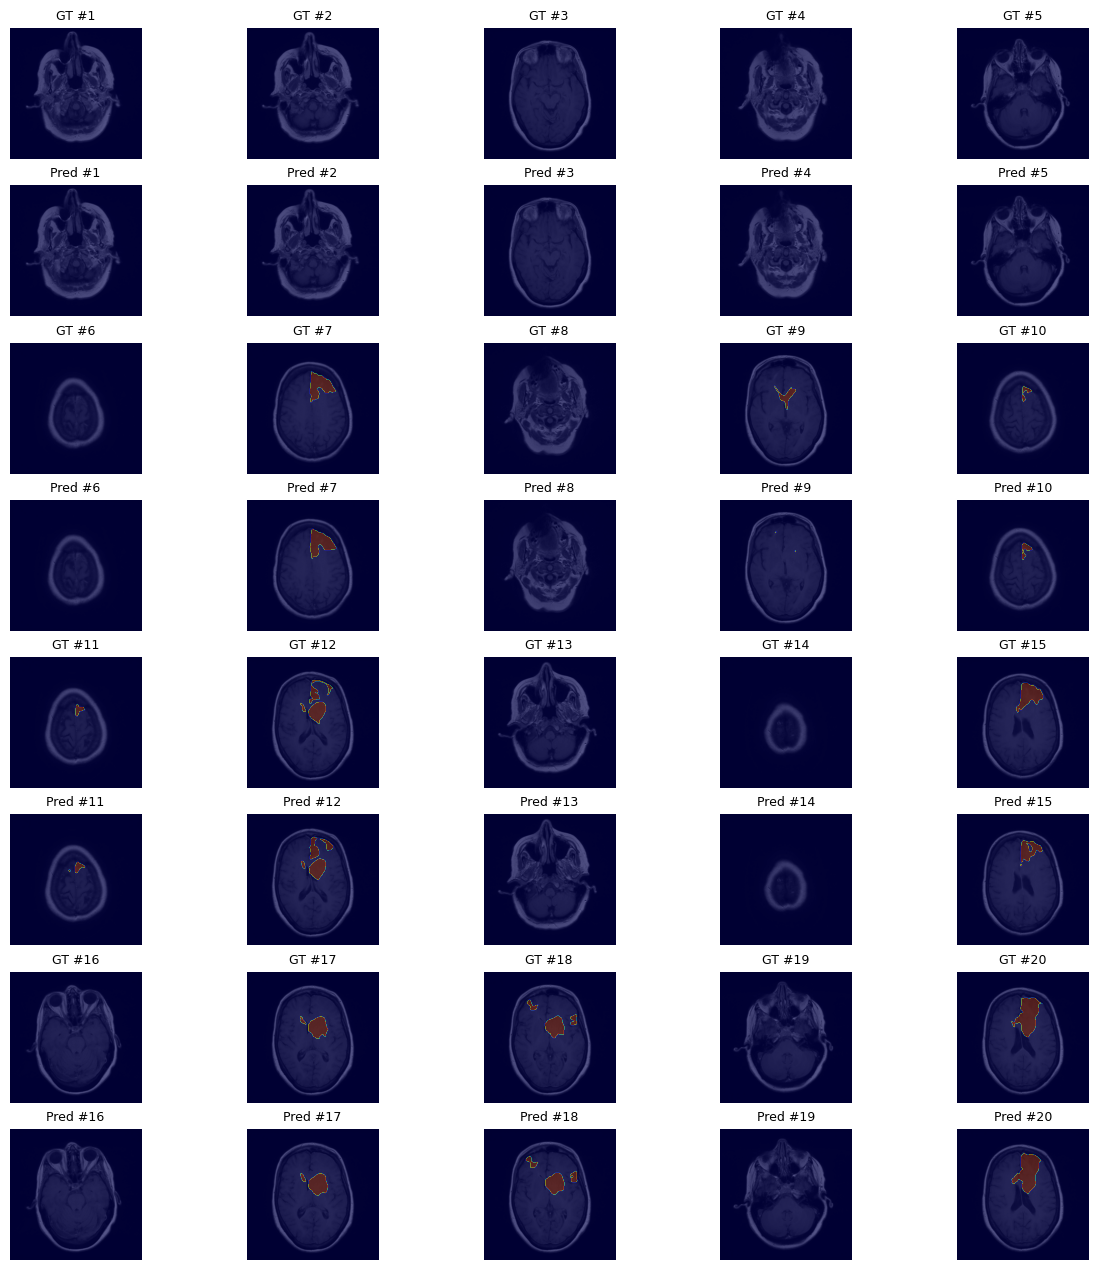

In [44]:
show_predictions_vertical_pairs(model, list(df["images"]), list(df["masks"]), num_groups=20, groups_per_row=5)


In [ ]:
def show_predictions_triplets(
    model, image_rgb_paths, mask_paths, image_tensors,
    num_groups=10, start_idx=0, all_image_rgb_paths=None
):
    model.eval()
    cols = 3

    fig = plt.figure(figsize=(cols * 3, num_groups * 2.5))
    gs = gridspec.GridSpec(num_groups, cols, wspace=0.1, hspace=0.2)

    shown = 0

    for idx in range(start_idx, len(image_rgb_paths)):
        if shown >= num_groups:
            break

        img_path = image_rgb_paths[idx]
        mask_path = mask_paths[idx]

        gt_mask = cv.imread(mask_path, cv.IMREAD_GRAYSCALE)
        if gt_mask is None or np.sum(gt_mask) == 0:
            continue

        image_rgb = cv.imread(img_path, cv.IMREAD_COLOR)
        image_rgb = cv.cvtColor(image_rgb, cv.COLOR_BGR2RGB)

        img_tensor = image_tensors[idx].unsqueeze(0).cuda()
        with torch.no_grad():
            pred = torch.sigmoid(model(img_tensor))
            pred_mask = (pred > 0.5).float().squeeze().cpu().numpy()

        # 计算在全集中的索引
        if all_image_rgb_paths is not None:
            try:
                original_index = all_image_rgb_paths.index(img_path)
                title = f"Brain MRI"
            except ValueError:
                title = "Image (Index N/A)"
        else:
            title = f"Image #{idx+1}"

        ax_img = fig.add_subplot(gs[shown, 0])
        ax_img.imshow(image_rgb)
        ax_img.set_title(title, fontsize=9)
        ax_img.axis("off")

        ax_gt = fig.add_subplot(gs[shown, 1])
        ax_gt.imshow(gt_mask, cmap="gray")
        ax_gt.set_title("Ground Truth", fontsize=9)
        ax_gt.axis("off")

        ax_pred = fig.add_subplot(gs[shown, 2])
        ax_pred.imshow(pred_mask, cmap="gray")
        ax_pred.set_title("Prediction", fontsize=9)
        ax_pred.axis("off")

        shown += 1

    plt.tight_layout()
    plt.show()


In [ ]:
def show_predictions_triplets(
    model, image_rgb_paths, mask_paths, image_tensors,
    num_groups=10, start_idx=0, all_image_rgb_paths=None
):
    model.eval()
    cols = 3
    fig = plt.figure(figsize=(9, 3 * num_groups))
    gs = gridspec.GridSpec(num_groups, cols)
    shown = 0
    for idx in range(start_idx, len(image_rgb_paths)):
        if shown >= num_groups:
            break
        img_path = image_rgb_paths[idx]
        mask_path = mask_paths[idx]
        gt_mask = cv.imread(mask_path, cv.IMREAD_GRAYSCALE)
        if gt_mask is None or np.sum(gt_mask) == 0:
            continue
        image_rgb = cv.imread(img_path, cv.IMREAD_COLOR)
        image_rgb = cv.cvtColor(image_rgb, cv.COLOR_BGR2RGB)
        img_tensor = image_tensors[idx].unsqueeze(0).cuda()
        with torch.no_grad():
            pred = torch.sigmoid(model(img_tensor))
            pred_mask = (pred > 0.5).float().squeeze().cpu().numpy()
        # Calculate the index over the entire set
        if all_image_rgb_paths is not None:
            try:
                original_index = all_image_rgb_paths.index(img_path)
                title = f"Brain MRI"
            except ValueError:
                title = "Image (Index N/A)"
        else:
            title = f"Image #{idx+1}"
        ax_img = fig.add_subplot(gs[shown, 0])
        ax_img.imshow(image_rgb)
        ax_img.set_title(title) 
        ax_img.axis("off")
        ax_gt = fig.add_subplot(gs[shown, 1])
        ax_gt.imshow(gt_mask, cmap="gray")
        ax_gt.set_title("ground truth")  
        ax_gt.axis("off")
        ax_pred = fig.add_subplot(gs[shown, 2])
        ax_pred.imshow(pred_mask, cmap="gray")
        ax_pred.set_title("prediction") 
        ax_pred.axis("off")
        shown += 1
    plt.tight_layout()
    plt.show()

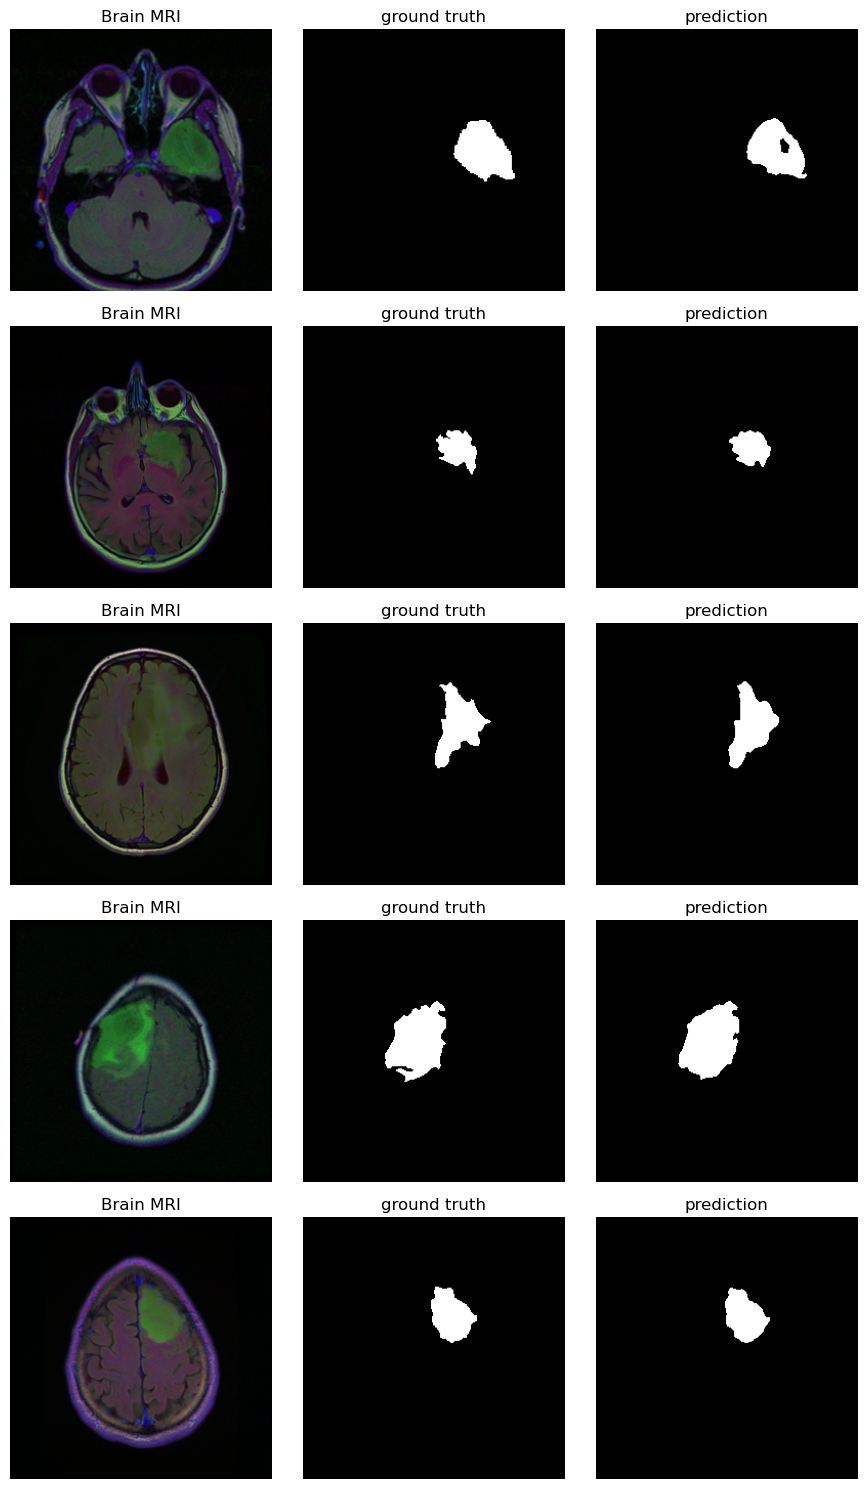

In [ ]:
show_predictions_triplets(
    model,
    image_rgb_paths=test_img_paths,
    mask_paths=test_mask_paths,
    image_tensors=test_img,
    num_groups=5,
    start_idx=30,
    all_image_rgb_paths=image_rgb_paths  # Original full path list
)


# -------------------------
# Model 4 SwinUNETR

In [ ]:
model = SwinUNETR(
    img_size=(256, 256),     
    in_channels=1,           
    out_channels=1,          
    spatial_dims=2      
).cuda()

loss_function = BCEDiceLoss(bce_weight=0.5)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [27]:
total_epoch = 200
best_dice = 0.0
patience = 10  # 可以调整
counter = 0
early_stop = False

print('Begin to train!!')
for epoch in range(total_epoch):
    if early_stop:
        print("Early stopping triggered at epoch", epoch)
        break

    model.train()
    epoch_loss = 0.0
    batch_idx = 0
    for img, mask in tqdm(trainloader):
        batch_idx += 1
        img, mask = img.cuda(), mask.cuda().float()
        optimizer.zero_grad()
        output = model(img)
        output = torch.sigmoid(output)
        
        loss = loss_function(output, mask)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= batch_idx
    print('Epoch {} loss: {:.4f}'.format(epoch, epoch_loss))

    if (epoch + 1) % 5 == 0:
        model.eval()
        print('Begin to validate!!')
        with torch.no_grad():
            val_loss = 0.0
            val_dice = 0.0
            val_idx = 0
            for val_img, val_mask in tqdm(valloader):
                val_idx += 1
                val_img, val_mask = val_img.cuda(), val_mask.cuda().float()
                val_output = model(val_img)
                val_output = torch.sigmoid(val_output)

                loss = loss_function(val_output, val_mask)
                val_loss += loss.item()
                val_dice += dice_coefficient(val_output, val_mask)
        val_loss /= val_idx
        val_dice /= val_idx

        print('Validation ended !!')
        print('Dice: {:.4f}, Loss: {:.4f}'.format(val_dice, val_loss))

        if val_dice > best_dice:
            best_dice = val_dice
            counter = 0
            torch.save(model.state_dict(), 'SwinUNETR_model.pth')
            print(f"✅ New best Dice {best_dice:.4f}, model saved.")
        else:
            counter += 1
            print(f"⚠️  No improvement. Early stop counter: {counter}/{patience}")
            if counter >= patience:
                early_stop = True

print('Training ended !!')


Begin to train!!


100%|██████████| 50/50 [00:46<00:00,  1.08it/s]


Epoch 0 loss: 0.6616


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Epoch 1 loss: 0.5966


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 2 loss: 0.5706


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Epoch 3 loss: 0.5518


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 4 loss: 0.5358
Begin to validate!!


100%|██████████| 7/7 [00:03<00:00,  2.25it/s]


Validation ended !!
Dice: 0.1068, Loss: 0.5290
✅ New best Dice 0.1068, model saved.


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 5 loss: 0.5211


100%|██████████| 50/50 [00:22<00:00,  2.24it/s]


Epoch 6 loss: 0.5095


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 7 loss: 0.4959


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 8 loss: 0.4862


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 9 loss: 0.4753
Begin to validate!!


100%|██████████| 7/7 [00:02<00:00,  2.66it/s]


Validation ended !!
Dice: 0.1608, Loss: 0.4740
✅ New best Dice 0.1608, model saved.


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 10 loss: 0.4657


100%|██████████| 50/50 [00:22<00:00,  2.24it/s]


Epoch 11 loss: 0.4564


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 12 loss: 0.4482


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 13 loss: 0.4374


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 14 loss: 0.4270
Begin to validate!!


100%|██████████| 7/7 [00:02<00:00,  2.70it/s]


Validation ended !!
Dice: 0.2149, Loss: 0.4316
✅ New best Dice 0.2149, model saved.


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 15 loss: 0.4190


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 16 loss: 0.4104


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Epoch 17 loss: 0.4001


100%|██████████| 50/50 [00:22<00:00,  2.24it/s]


Epoch 18 loss: 0.3957


100%|██████████| 50/50 [00:22<00:00,  2.24it/s]


Epoch 19 loss: 0.3829
Begin to validate!!


100%|██████████| 7/7 [00:02<00:00,  2.63it/s]


Validation ended !!
Dice: 0.2781, Loss: 0.3898
✅ New best Dice 0.2781, model saved.


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 20 loss: 0.3743


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 21 loss: 0.3674


100%|██████████| 50/50 [00:28<00:00,  1.77it/s]


Epoch 22 loss: 0.3549


100%|██████████| 50/50 [00:23<00:00,  2.15it/s]


Epoch 23 loss: 0.3460


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Epoch 24 loss: 0.3365
Begin to validate!!


100%|██████████| 7/7 [00:02<00:00,  2.41it/s]


Validation ended !!
Dice: 0.3433, Loss: 0.3509
✅ New best Dice 0.3433, model saved.


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Epoch 25 loss: 0.3275


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 26 loss: 0.3170


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 27 loss: 0.3087


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Epoch 28 loss: 0.2972


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 29 loss: 0.2925
Begin to validate!!


100%|██████████| 7/7 [00:02<00:00,  2.45it/s]


Validation ended !!
Dice: 0.4186, Loss: 0.3095
✅ New best Dice 0.4186, model saved.


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 30 loss: 0.2854


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 31 loss: 0.2723


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 32 loss: 0.2639


100%|██████████| 50/50 [00:22<00:00,  2.20it/s]


Epoch 33 loss: 0.2561


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 34 loss: 0.2220
Begin to validate!!


100%|██████████| 7/7 [00:02<00:00,  2.63it/s]


Validation ended !!
Dice: 0.5478, Loss: 0.2385
✅ New best Dice 0.5478, model saved.


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Epoch 35 loss: 0.2000


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 36 loss: 0.1895


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 37 loss: 0.1860


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 38 loss: 0.1747


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 39 loss: 0.1585
Begin to validate!!


100%|██████████| 7/7 [00:02<00:00,  2.66it/s]


Validation ended !!
Dice: 0.6269, Loss: 0.1965
✅ New best Dice 0.6269, model saved.


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 40 loss: 0.1469


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 41 loss: 0.1386


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 42 loss: 0.1305


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 43 loss: 0.1321


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 44 loss: 0.1200
Begin to validate!!


100%|██████████| 7/7 [00:02<00:00,  2.61it/s]


Validation ended !!
Dice: 0.6827, Loss: 0.1685
✅ New best Dice 0.6827, model saved.


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 45 loss: 0.1155


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 46 loss: 0.1089


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 47 loss: 0.1042


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Epoch 48 loss: 0.1000


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 49 loss: 0.0939
Begin to validate!!


100%|██████████| 7/7 [00:02<00:00,  2.62it/s]


Validation ended !!
Dice: 0.7227, Loss: 0.1479
✅ New best Dice 0.7227, model saved.


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Epoch 50 loss: 0.0911


100%|██████████| 50/50 [00:27<00:00,  1.84it/s]


Epoch 51 loss: 0.0857


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Epoch 52 loss: 0.0845


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Epoch 53 loss: 0.0831


100%|██████████| 50/50 [00:22<00:00,  2.20it/s]


Epoch 54 loss: 0.0838
Begin to validate!!


100%|██████████| 7/7 [00:02<00:00,  2.49it/s]


Validation ended !!
Dice: 0.7451, Loss: 0.1368
✅ New best Dice 0.7451, model saved.


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 55 loss: 0.0736


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 56 loss: 0.0713


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 57 loss: 0.0713


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 58 loss: 0.0665


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 59 loss: 0.0651
Begin to validate!!


100%|██████████| 7/7 [00:02<00:00,  2.67it/s]


Validation ended !!
Dice: 0.7675, Loss: 0.1257
✅ New best Dice 0.7675, model saved.


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 60 loss: 0.0708


100%|██████████| 50/50 [00:22<00:00,  2.24it/s]


Epoch 61 loss: 0.0588


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Epoch 62 loss: 0.0592


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 63 loss: 0.0577


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 64 loss: 0.0540
Begin to validate!!


100%|██████████| 7/7 [00:02<00:00,  2.71it/s]


Validation ended !!
Dice: 0.7794, Loss: 0.1201
✅ New best Dice 0.7794, model saved.


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 65 loss: 0.0507


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 66 loss: 0.0504


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 67 loss: 0.0483


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 68 loss: 0.0535


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 69 loss: 0.0501
Begin to validate!!


100%|██████████| 7/7 [00:02<00:00,  2.54it/s]


Validation ended !!
Dice: 0.7914, Loss: 0.1143
✅ New best Dice 0.7914, model saved.


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Epoch 70 loss: 0.0463


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Epoch 71 loss: 0.0438


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 72 loss: 0.0419


100%|██████████| 50/50 [00:22<00:00,  2.24it/s]


Epoch 73 loss: 0.0412


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 74 loss: 0.0395
Begin to validate!!


100%|██████████| 7/7 [00:02<00:00,  2.65it/s]


Validation ended !!
Dice: 0.7953, Loss: 0.1125
✅ New best Dice 0.7953, model saved.


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 75 loss: 0.0387


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 76 loss: 0.0394


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 77 loss: 0.0374


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 78 loss: 0.0362


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 79 loss: 0.0344
Begin to validate!!


100%|██████████| 7/7 [00:02<00:00,  2.70it/s]


Validation ended !!
Dice: 0.8090, Loss: 0.1057
✅ New best Dice 0.8090, model saved.


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 80 loss: 0.0336


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Epoch 81 loss: 0.0325


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 82 loss: 0.0309


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 83 loss: 0.0304


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 84 loss: 0.0297
Begin to validate!!


100%|██████████| 7/7 [00:02<00:00,  2.54it/s]


Validation ended !!
Dice: 0.8161, Loss: 0.1025
✅ New best Dice 0.8161, model saved.


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Epoch 85 loss: 0.0301


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 86 loss: 0.0296


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 87 loss: 0.0285


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 88 loss: 0.0282


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Epoch 89 loss: 0.0278
Begin to validate!!


100%|██████████| 7/7 [00:02<00:00,  2.34it/s]


Validation ended !!
Dice: 0.8202, Loss: 0.1004
✅ New best Dice 0.8202, model saved.


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 90 loss: 0.0281


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 91 loss: 0.0297


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 92 loss: 0.0306


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Epoch 93 loss: 0.0270


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Epoch 94 loss: 0.0258
Begin to validate!!


100%|██████████| 7/7 [00:04<00:00,  1.72it/s]


Validation ended !!
Dice: 0.8213, Loss: 0.1003
✅ New best Dice 0.8213, model saved.


100%|██████████| 50/50 [00:22<00:00,  2.19it/s]


Epoch 95 loss: 0.0252


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 96 loss: 0.0242


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 97 loss: 0.0232


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 98 loss: 0.0225


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 99 loss: 0.0215
Begin to validate!!


100%|██████████| 7/7 [00:02<00:00,  2.56it/s]


Validation ended !!
Dice: 0.8243, Loss: 0.0992
✅ New best Dice 0.8243, model saved.


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 100 loss: 0.0209


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 101 loss: 0.0240


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 102 loss: 0.0309


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 103 loss: 0.0204


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Epoch 104 loss: 0.0196
Begin to validate!!


100%|██████████| 7/7 [00:02<00:00,  2.58it/s]


Validation ended !!
Dice: 0.8239, Loss: 0.0995
⚠️  No improvement. Early stop counter: 1/10


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 105 loss: 0.0193


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Epoch 106 loss: 0.0192


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 107 loss: 0.0201


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Epoch 108 loss: 0.0199


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 109 loss: 0.0186
Begin to validate!!


100%|██████████| 7/7 [00:02<00:00,  2.67it/s]


Validation ended !!
Dice: 0.8298, Loss: 0.0965
✅ New best Dice 0.8298, model saved.


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 110 loss: 0.0178


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 111 loss: 0.0174


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 112 loss: 0.0170


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 113 loss: 0.0173


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 114 loss: 0.0182
Begin to validate!!


100%|██████████| 7/7 [00:02<00:00,  2.66it/s]


Validation ended !!
Dice: 0.8293, Loss: 0.0970
⚠️  No improvement. Early stop counter: 1/10


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 115 loss: 0.0174


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 116 loss: 0.0164


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 117 loss: 0.0170


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Epoch 118 loss: 0.0168


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 119 loss: 0.0173
Begin to validate!!


100%|██████████| 7/7 [00:02<00:00,  2.67it/s]


Validation ended !!
Dice: 0.8303, Loss: 0.0972
✅ New best Dice 0.8303, model saved.


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 120 loss: 0.0196


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Epoch 121 loss: 0.0174


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Epoch 122 loss: 0.0161


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 123 loss: 0.0151


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 124 loss: 0.0146
Begin to validate!!


100%|██████████| 7/7 [00:02<00:00,  2.63it/s]


Validation ended !!
Dice: 0.8310, Loss: 0.0964
✅ New best Dice 0.8310, model saved.


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 125 loss: 0.0142


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 126 loss: 0.0139


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 127 loss: 0.0136


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 128 loss: 0.0132


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 129 loss: 0.0131
Begin to validate!!


100%|██████████| 7/7 [00:02<00:00,  2.61it/s]


Validation ended !!
Dice: 0.8354, Loss: 0.0946
✅ New best Dice 0.8354, model saved.


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 130 loss: 0.0142


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 131 loss: 0.0139


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 132 loss: 0.0228


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Epoch 133 loss: 0.0128


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Epoch 134 loss: 0.0132
Begin to validate!!


100%|██████████| 7/7 [00:02<00:00,  2.61it/s]


Validation ended !!
Dice: 0.8326, Loss: 0.0961
⚠️  No improvement. Early stop counter: 1/10


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 135 loss: 0.0129


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 136 loss: 0.0122


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Epoch 137 loss: 0.0118


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 138 loss: 0.0115


100%|██████████| 50/50 [00:22<00:00,  2.20it/s]


Epoch 139 loss: 0.0111
Begin to validate!!


100%|██████████| 7/7 [00:02<00:00,  2.69it/s]


Validation ended !!
Dice: 0.8359, Loss: 0.0945
✅ New best Dice 0.8359, model saved.


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Epoch 140 loss: 0.0112


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 141 loss: 0.0113


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 142 loss: 0.0114


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 143 loss: 0.0114


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 144 loss: 0.0114
Begin to validate!!


100%|██████████| 7/7 [00:02<00:00,  2.69it/s]


Validation ended !!
Dice: 0.8357, Loss: 0.0950
⚠️  No improvement. Early stop counter: 1/10


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 145 loss: 0.0187


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 146 loss: 0.0168


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 147 loss: 0.0138


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 148 loss: 0.0120


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 149 loss: 0.0115
Begin to validate!!


100%|██████████| 7/7 [00:02<00:00,  2.56it/s]


Validation ended !!
Dice: 0.8373, Loss: 0.0940
✅ New best Dice 0.8373, model saved.


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Epoch 150 loss: 0.0113


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 151 loss: 0.0112


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Epoch 152 loss: 0.0111


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 153 loss: 0.0109


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 154 loss: 0.0117
Begin to validate!!


100%|██████████| 7/7 [00:02<00:00,  2.67it/s]


Validation ended !!
Dice: 0.8343, Loss: 0.0958
⚠️  No improvement. Early stop counter: 1/10


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 155 loss: 0.0104


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 156 loss: 0.0095


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 157 loss: 0.0097


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Epoch 158 loss: 0.0090


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Epoch 159 loss: 0.0185
Begin to validate!!


100%|██████████| 7/7 [00:02<00:00,  2.57it/s]


Validation ended !!
Dice: 0.8314, Loss: 0.0980
⚠️  No improvement. Early stop counter: 2/10


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 160 loss: 0.0093


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 161 loss: 0.0099


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Epoch 162 loss: 0.0093


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 163 loss: 0.0088


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Epoch 164 loss: 0.0087
Begin to validate!!


100%|██████████| 7/7 [00:02<00:00,  2.71it/s]


Validation ended !!
Dice: 0.8316, Loss: 0.0978
⚠️  No improvement. Early stop counter: 3/10


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 165 loss: 0.0083


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Epoch 166 loss: 0.0091


100%|██████████| 50/50 [00:23<00:00,  2.16it/s]


Epoch 167 loss: 0.0125


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Epoch 168 loss: 0.0107


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 169 loss: 0.0090
Begin to validate!!


100%|██████████| 7/7 [00:02<00:00,  2.67it/s]


Validation ended !!
Dice: 0.8368, Loss: 0.0950
⚠️  No improvement. Early stop counter: 4/10


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 170 loss: 0.0084


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 171 loss: 0.0079


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 172 loss: 0.0079


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 173 loss: 0.0078


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 174 loss: 0.0077
Begin to validate!!


100%|██████████| 7/7 [00:02<00:00,  2.60it/s]


Validation ended !!
Dice: 0.8287, Loss: 0.1000
⚠️  No improvement. Early stop counter: 5/10


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 175 loss: 0.0080


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 176 loss: 0.0098


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Epoch 177 loss: 0.0086


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 178 loss: 0.0081


100%|██████████| 50/50 [00:35<00:00,  1.40it/s]


Epoch 179 loss: 0.0081
Begin to validate!!


100%|██████████| 7/7 [00:03<00:00,  2.03it/s]


Validation ended !!
Dice: 0.8345, Loss: 0.0965
⚠️  No improvement. Early stop counter: 6/10


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 180 loss: 0.0079


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 181 loss: 0.0076


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 182 loss: 0.0075


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 183 loss: 0.0074


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 184 loss: 0.0073
Begin to validate!!


100%|██████████| 7/7 [00:02<00:00,  2.58it/s]


Validation ended !!
Dice: 0.8358, Loss: 0.0961
⚠️  No improvement. Early stop counter: 7/10


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 185 loss: 0.0075


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 186 loss: 0.0194


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 187 loss: 0.0083


100%|██████████| 50/50 [00:22<00:00,  2.24it/s]


Epoch 188 loss: 0.0076


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 189 loss: 0.0072
Begin to validate!!


100%|██████████| 7/7 [00:02<00:00,  2.68it/s]


Validation ended !!
Dice: 0.8349, Loss: 0.0965
⚠️  No improvement. Early stop counter: 8/10


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 190 loss: 0.0070


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 191 loss: 0.0075


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 192 loss: 0.0080


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Epoch 193 loss: 0.0175


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 194 loss: 0.0068
Begin to validate!!


100%|██████████| 7/7 [00:02<00:00,  2.50it/s]


Validation ended !!
Dice: 0.8332, Loss: 0.0977
⚠️  No improvement. Early stop counter: 9/10


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Epoch 195 loss: 0.0069


100%|██████████| 50/50 [00:23<00:00,  2.17it/s]


Epoch 196 loss: 0.0067


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 197 loss: 0.0168


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 198 loss: 0.0065


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 199 loss: 0.0068
Begin to validate!!


100%|██████████| 7/7 [00:02<00:00,  2.70it/s]


Validation ended !!
Dice: 0.8337, Loss: 0.0974
⚠️  No improvement. Early stop counter: 10/10
Training ended !!


In [40]:
model.load_state_dict(torch.load('SwinUNETR_model.pth'))
model.cuda()
model.eval()
batch_idx = 0
test_dice = 0.0
test_hd = 0.0
test_iou = 0.0
test_recall = 0.0

for img, mask in tqdm(testloader):
    batch_idx += 1
    img = img.cuda()
    mask = mask.cuda().float()

    with torch.no_grad():
        raw_output = torch.sigmoid(model(img))
        binary_output = (raw_output > 0.5).float()

        # Dice
        test_dice += dice_coefficient(binary_output, mask)

        # IoU & Recall
        iou, recall = compute_metrics(binary_output, mask)
        test_iou += iou
        test_recall += recall

        # Hausdorff Distance
        hd_output = binary_output.cpu().detach().numpy()
        hd_mask = mask.cpu().detach().numpy()
        hd = 0.0
        for i in range(binary_output.shape[0]):
            hd += directed_hausdorff(hd_output[i].squeeze(), hd_mask[i].squeeze())[0]
        test_hd += hd / binary_output.shape[0]

# Final averaged metrics
test_dice /= batch_idx
test_iou /= batch_idx
test_recall /= batch_idx
test_hd /= batch_idx

print(f'During test of SwinUNETR_model :\n'
      f'  Dice:   {test_dice:.4f}\n'
      f'  IoU:    {test_iou:.4f}\n'
      f'  Recall: {test_recall:.4f}\n'
      f'  HD:     {test_hd:.4f} pixels')


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
100%|██████████| 7/7 [00:10<00:00,  1.51s/it]

During test of SwinUNETR_model :
  Dice:   0.7537
  IoU:    0.6458
  Recall: 0.7099
  HD:     1.0800 pixels


This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


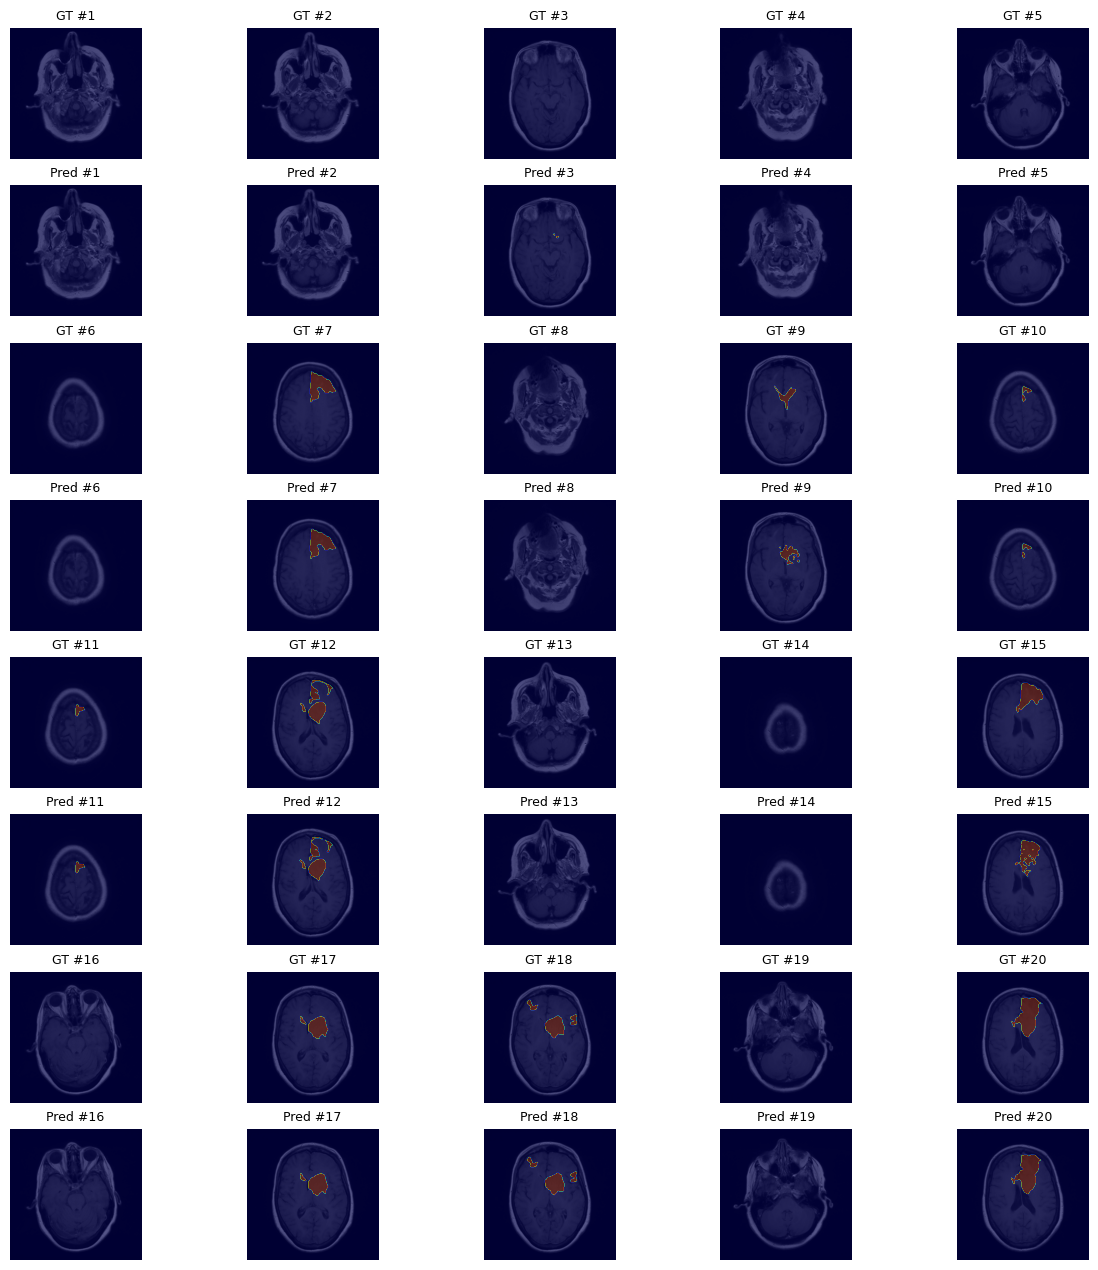

In [52]:
show_predictions_vertical_pairs(model, list(df["images"]), list(df["masks"]), num_groups=20, groups_per_row=5)


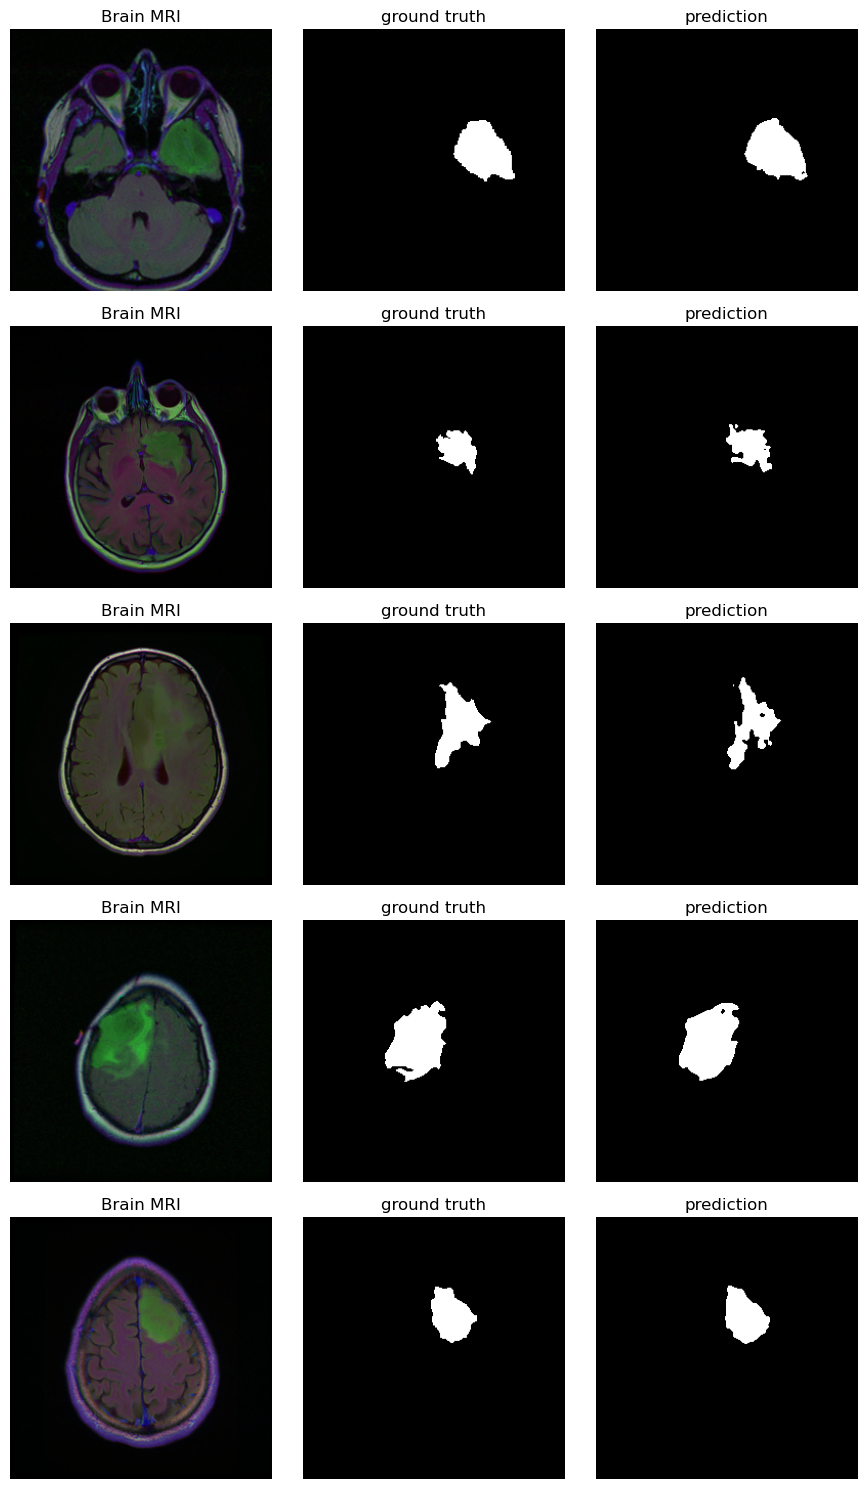

In [41]:
show_predictions_triplets(
    model,
    image_rgb_paths=test_img_paths,
    mask_paths=test_mask_paths,
    image_tensors=test_img,
    num_groups=5,
    start_idx=30,
    all_image_rgb_paths=image_rgb_paths    
)
